MIT License

Copyright (c) 2021 Taiki Miyagawa and Akinori F. Ebihara

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

# <font color=red> Lite version reduces GPU memory consumption at the expense of CPU memory and runtime. </font> Take care of  your CPU memory.

# Plot Speed-Accuracy Tradeoff (SAT) Curve of Validation dataset

In [3]:
from __future__ import absolute_import, division, print_function

import os, sys, glob, time
from itertools import zip_longest
import optuna
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatter, ScalarFormatter, NullFormatter
import numpy as np
import tensorflow as tf

from datasets.data_processing import read_tfrecords_UCF101,\
    decode_feat, sequential_slice, sequential_concat
from models.backbones_ti import LSTMModelLite
from models.optimizers import get_optimizer
from models.losses import get_gradient_lstm
from utils.misc import load_yaml, set_gpu_devices, fix_random_seed,\
    restrict_classes, extract_positive_row, add_max_to_diag
from utils.performance_metrics import multiplet_sequential_confmx,\
    llr_sequential_confmx,\
    truncated_MSPRT, threshold_generator,\
    calc_llrs, calc_oblivious_llrs, threshold_generator, thresh_sanity_check,\
    NP_test,\
    get_LLR_min_and_max, get_linspace, threshold_generator_with_values,\
    seqconfmx_to_metrics

# User-defined params

In [4]:
# User-defined
order_sprt = 10 # order of MSPRT-TANDEM
oblivious = False # M-TANDEM (False) or M-TANDEMwO (True)
name_model = "./data-directory/sprt_multiclass/UCF101/ckptlogs/MSPRT-TANDEM_ver20210331_stat/__20210424_150952523/" # for example

In [5]:
# User-defined
num_thresh = 10 # Total number of thresholds to be used to plot the SAT curve
batch_thresh = 5 # Memory consuming!! How many thresholds to be feeded at a time. < 10 is recommended
sparsity = "linspace" # "linspace" or logspace". Used for threshold generation.
class_plot = -2 # -1:micro-averaged recall, -2:macro-averaged recall.
dataname = "UCF101-50-240-320" # "UCF101-150-240-320", "UCF101-50-256-256", ...

tfr_train = "DATADIR/UCF101TFR-50-240-320/train01.tfrecords"
tfr_valid = "DATADIR/UCF101TFR-50-240-320/valid01.tfrecords"
tfr_test = "DATADIR/UCF101TFR-50-240-320/test01.tfrecords"
batch_size = 100 # Must be a divisor of the num of test datapoints. Memory consumption << batch_thresh.
batch_size2 = 50 # used for calc_llrs, NP_test, and trundated_MSPRT. Not necessarily a divisor of the sample size.
gpu = 0 # Which GPU to be used

assert num_thresh % batch_thresh == 0 # Make sure

In [6]:
# Must be consistent with the model (name_model).
duration = 50 
feat_dim = 2048 # input feature dimension
num_classes = 101
width_lstm = 256 # dim of hidden layers of LSTM
dropout = 0.
activation = "tanh"

In [8]:
# Which GPU to be used
set_gpu_devices(gpu)

# 0. Start calc logits and LLRs

In [9]:
# Load data
##################################
# Reed tfr and make 
dataset_tr, dataset_va,\
    dataset_te = \
    read_tfrecords_UCF101(
        record_file_tr=tfr_train, 
        record_file_va=tfr_valid,
        record_file_te=tfr_test,
        batch_size=batch_size, 
        flag_shuffle=False,
        shuffle_buffer_size=10000)

# Model
##################################
model = LSTMModelLite(
    num_classes=num_classes, 
    width_lstm=width_lstm, 
    dropout=dropout, 
    activation=activation) 

# Restore parameters
#################################
ckpt = tf.train.Checkpoint(net=model)
ckpt_manager_restore = tf.train.CheckpointManager(ckpt,
    name_model, max_to_keep=3)
ckpt.restore(ckpt_manager_restore.latest_checkpoint)
print("Restored latest model\n{}".format(
    ckpt_manager_restore.latest_checkpoint)) 

# Evaluaton loop
##################################
for iter_b, feats in enumerate(dataset_va):
    cnt = iter_b + 1

    x_batch = feats[0]
    x_batch = tf.reshape(x_batch, (-1, duration, feat_dim)) 
        # (batch, duration, feat dims)
    y_batch = feats[1]
        # (batch, )

    x_slice, y_slice = sequential_slice(x_batch, y_batch, order_sprt)

    # Calc logits 
    if iter_b == 0:
        ls_logits = []
        ls_labels = []

    # Calc loss
    logits_tmp = model(x_slice, False)
    logits_tmp, _ = sequential_concat(logits_tmp, y_slice, duration) 

    ls_logits.append(logits_tmp.numpy()) 
    ls_labels.append(y_batch.numpy()) 

    # Verbose
    if ((iter_b+1)%10 == 0) or (iter_b == 0):
        sys.stdout.write("\rEvaluation Iter: {:3d}".format(iter_b+1))
        sys.stdout.flush()

print()
logits_all = np.concatenate(ls_logits, axis=0) 
labels_all = np.concatenate(ls_labels, axis=0) 

Restored latest model
/data/t-miyagawa/sprt_multiclass/UCF101/ckptlogs/50-240-320_ME_CSL_ver20210331_stat/__20210424_150952523/ckpt_step2600_macrec0.83303-10
Evaluation Iter:  40


In [10]:
# Calc LLRs  
num_data = labels_all.shape[0]
num_iter = num_data // batch_size2 if num_data % batch_size2 == 0 else num_data // batch_size2 + 1
llrs_all = []
start = -1
stop = -1
for i in range(num_iter):    
    itr_logits = logits_all[i * batch_size2 : (i + 1) * batch_size2]

    if oblivious:
        itr_llrs = calc_oblivious_llrs(itr_logits)
    else:
        itr_llrs = calc_llrs(itr_logits)

    llrs_all.append(itr_llrs.numpy())        
        
    # Used to generate thresholds
    tmp_start, tmp_stop = get_LLR_min_and_max(itr_llrs) # A bit memory consuming.
    tmp_start = tmp_start.numpy()
    tmp_stop = tmp_stop.numpy()

    if i == 0:
        start = tmp_start
        stop = tmp_stop
        continue
    
    if tmp_start < start:
        start = tmp_start
    if tmp_stop > stop:
        stop = tmp_stop

    # Verbose
    if ((iter_b + 1) % 10 == 0) or (iter_b == 0):
        sys.stdout.write("\rEvaluation Iter: {:3d}/{}".format(iter_b+1, num_iter))
        sys.stdout.flush()

        
values = get_linspace(start, stop, num_thresh, sparsity).numpy()
llrs_all = np.concatenate(llrs_all, axis=0)

In [11]:
tic = time.time()
print("This cell takes a few minutes because of the two mini-batch processes...")

# Batch processing for thresh axis to save GPU memory 
######################################################
num_data = labels_all.shape[0]
ls_confmx_th = []
ls_mht_th = []
ls_vht_th = []
ls_trt_th = []
for i in range(num_thresh // batch_thresh):
    print("Thresh Iter {}/{} ...".format(i+1, num_thresh // batch_thresh))
    
    # Generate Thresholds for SPRT
    idx = batch_thresh * i
    itr_values = values[idx : idx + batch_thresh]
    itr_thresh = threshold_generator_with_values(itr_values, duration, num_classes) # memory consuming
    thresh_sanity_check(itr_thresh)
    
    # Batch processing for data axis to save GPU memory
    ####################################################
    num_iter = num_data // batch_size2 if num_data % batch_size2 == 0 else num_data // batch_size2 + 1
    tmp_confmx_th = 0
    tmp_mht_th = []
    tmp_sqr_th = []
    tmp_trt_th = []
    for i in range(num_iter):
        itr_llrs = llrs_all[i * batch_size2 : (i + 1) * batch_size2]
        itr_labels = labels_all[i * batch_size2 : (i + 1) * batch_size2]
        _len = itr_labels.shape[0]

        # Confusion matrix of SPRT, mean/var hitting time, 
        # and truncation rate
        _tmp_confmx_th, _tmp_mht_th, _tmp_vht_th, _tmp_trt_th = \
            truncated_MSPRT(
                llr_mtx=itr_llrs,
                labels_concat=itr_labels,
                thresh_mtx=itr_thresh) 
                # Super GPU memory super-consuming 
                # if batch_thresh or batch_size2 is large.
            # The shapes of the outputs are:
            # (batch_thresh, num classes, num classes)
            # (batch_thresh,)
            # (batch_thresh,)
            # (batch_thresh,)
        _tmp_sqr_th = _tmp_vht_th + _tmp_mht_th ** 2
            
        tmp_confmx_th += _tmp_confmx_th.numpy()
        tmp_mht_th.append(np.expand_dims(_tmp_mht_th.numpy(), axis=0) * _len)
        tmp_sqr_th.append(np.expand_dims(_tmp_sqr_th.numpy(), axis=0) * _len)
        tmp_trt_th.append(np.expand_dims(_tmp_trt_th.numpy(), axis=0) * _len) #<- should be integers

    tmp_mht_th = np.concatenate(tmp_mht_th, axis=0) # (num_iter, batch_thresh)
    tmp_mht_th = np.sum(tmp_mht_th, axis=0) / num_data # (batch_thresh, )
    tmp_sqr_th = np.concatenate(tmp_sqr_th, axis=0) # (num_iter, batch_thresh)
    tmp_sqr_th = np.sum(tmp_sqr_th, axis=0) / num_data # (batch_thresh, )
    tmp_vht_th = tmp_sqr_th - tmp_mht_th ** 2 # (batch_thresh, )
    tmp_trt_th = np.concatenate(tmp_trt_th, axis=0) # (num_iter, batch_thresh)
    tmp_trt_th = np.sum(tmp_trt_th, axis=0) / num_data # (batch_thresh, )

    ls_confmx_th.append(tmp_confmx_th)
    ls_mht_th.append(tmp_mht_th)
    ls_vht_th.append(tmp_vht_th)
    ls_trt_th.append(tmp_trt_th)

confmx_th = np.concatenate(ls_confmx_th, axis=0) # (num thresh, num cls, num cls)
mht_th = np.concatenate(ls_mht_th, axis=0) # (num thresh, )
vht_th = np.concatenate(ls_vht_th, axis=0) # (num thresh, )
trt_th = np.concatenate(ls_trt_th, axis=0) # (num thresh, )

print(time.time() - tic, "seconds")

This cell takes a few minutes because of the two mini-batch processes...OMG
Thresh Iter 1/2 ...
Thresh Iter 2/2 ...
25.820960521697998 seconds


In [12]:
# SPRT results
###########################
# Extract recalls (sensitivities)
dc_mtr = seqconfmx_to_metrics(confmx_th)

# Output
ls_sns = dc_mtr["SNS"].numpy()
    # (num thresh, num classes + 2)
    # [[recall of class 0, 1, 2, ..., recall of the last class, balanced accuracy, accuracy], ...]

ls_mht = mht_th#.numpy()
    # (num thresh,)
ls_vht = vht_th#.numpy()
    # (num thresh,)
ls_trt = trt_th#.numpy()
    # (num thresh,)

    
# NPT confmx
############################
num_iter = num_data // batch_size2 if num_data % batch_size2 == 0 else num_data // batch_size2 + 1
seqconfmx_llr = 0

for i in range(num_iter):
    if (i + 1) % 50 == 0:
        print("Iter {}/{}".format(i+1, num_iter))

    itr_llrs = llrs_all[i * batch_size2 : (i + 1) * batch_size2]
    itr_labels = labels_all[i * batch_size2 : (i + 1) * batch_size2]

    _tmp_seqconfmx_llr = NP_test(itr_llrs, itr_labels)
        # (duration, num classes, num classes)
    seqconfmx_llr += _tmp_seqconfmx_llr.numpy()
        # (duration, num classes, num classes)
        

# NPT results
###########################
dc_mtr_llr = seqconfmx_to_metrics(seqconfmx_llr)

# Output
ls_sns_NPT = dc_mtr_llr["SNS"].numpy()
    # (duration, num classes + 2)
    # [[recall of class 0, 1, 2, ..., recall of the last class, balanced accuracy, accuracy], ...]
################## end TMmod 20210106 ###############

Iter 50/90


In [13]:
ls_trt # truncation rate. All 0 or all 1 signal a problem.

array([0.       , 0.3405927, 0.6012573, 0.8621464, 0.9986529, 1.       ,
       1.       , 1.       , 1.       , 1.       ], dtype=float32)

__Materials__
1. `ls_mht` 

2. `ls_vht` 

3. `ls_trt` 

4. `ls_sns` 

5. `ls_sns_NPT` 


# 1. Plot SAT (Speed-Accuracy Tradeoff) Curve

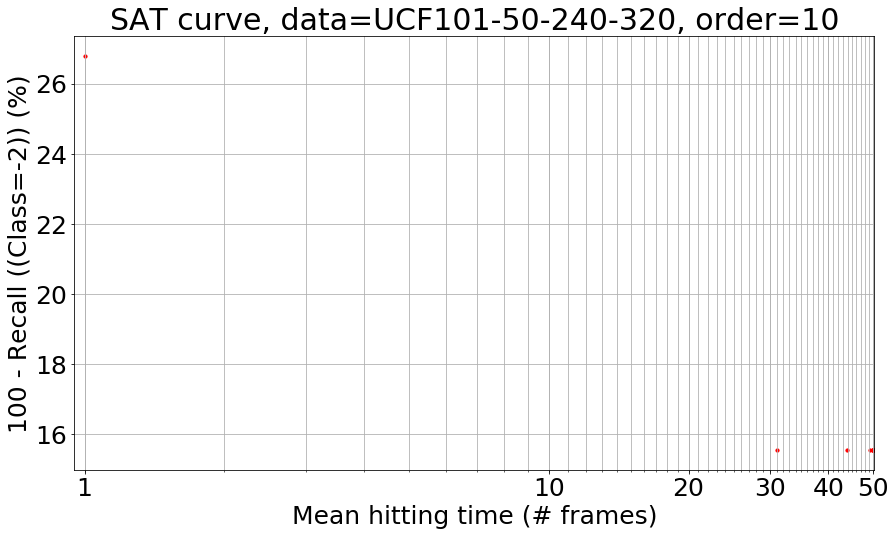

In [12]:
# Start plotting SP curve
######################################
# Parameters
x = ls_mht
y = 100 * (1 - ls_sns[:, class_plot]) # macro-averaged recall

title = "SAT curve, data={}, order={}".format(dataname, order_sprt)
xlabel = "Mean hitting time (# frames)"
if class_plot < num_classes:
    _tmp = "(Class={})".format(class_plot)
elif class_plot == num_classes:
    _tmp = "(Mac-ave)"
elif class_plot == num_classes + 1:
    _tmp = "(Mic-ave)"
else:
    raise ValueError
ylabel = "100 - Recall ({}) (%)".format(_tmp)


# Size
plt.rcParams["font.size"] = 25
fig, ax = plt.subplots(figsize=(13,8))
fig.patch.set_facecolor('white')
# Scale
ax.set_xscale('log')
# Grid
major_ticks = np.arange(0, duration + 1, 10)
major_ticks[0] += 1
minor_ticks = np.arange(0, duration + 1, 1)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_xticklabels(['0, 10, 20, 30, 40, 50'])
for axis in [ax.xaxis, ax.yaxis]: # ?
    axis.set_major_formatter(ScalarFormatter())
    axis.set_minor_formatter(NullFormatter())

# Plot
plt.scatter(
    x, y, 
    s=10, 
    color="red", 
    marker='o', 
    vmin=None, 
    vmax=None, 
    alpha=None, 
    linewidths=None,
    edgecolors=None
    )

plt.ylabel(ylabel)        
plt.xlabel(xlabel)
plt.grid(which='both')
#plt.legend(loc=None, fontsize='15')
plt.title(title)
plt.xlim(0.95, duration+0.3)# 1stO, 19thO
#plt.xlim(3.95, duration+0.3)# 1stO, 19thO
#plt.ylim(99.08, 99.65) # 1stO, 19thO
#plt.xlim(4.-0.3, duration+0.3)# 1stO, 19thO
#plt.ylim(70.08, 80.65) # 1stO, 19thO
plt.tight_layout()

# Save figure
#plt.savefig(***)

## 1-1. SPRT vs NPT

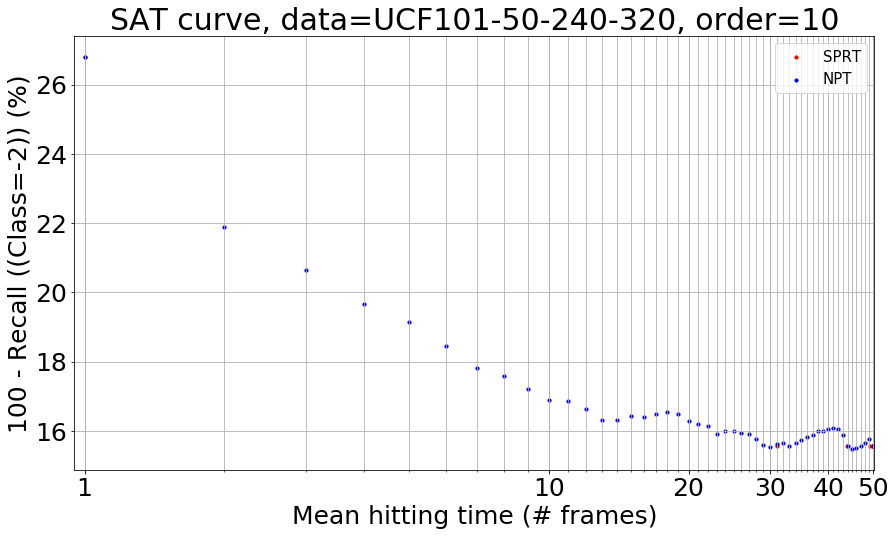

In [13]:
# Plot NPT vs SPRT
###############################
# Parameters
x = ls_mht
y = 100 * (1 - ls_sns[:, class_plot])
x_np = np.array([i + 1 for i in range(duration)])
y_np = 100 * (1 - ls_sns_NPT[:, class_plot])
label = "SPRT"
label_np = "NPT"
title = "SAT curve, data={}, order={}".format(dataname, order_sprt)
xlabel = "Mean hitting time (# frames)"
if class_plot < num_classes:
    _tmp = "(Class={})".format(class_plot)
elif class_plot == num_classes:
    _tmp = "(Mac-ave)"
elif class_plot == num_classes + 1:
    _tmp = "(Mic-ave)"
else:
    raise ValueError
ylabel = "100 - Recall ({}) (%)".format(_tmp)



# Size
plt.rcParams["font.size"] = 25
fig, ax = plt.subplots(figsize=(13,8))
# Scale
ax.set_xscale('log')
# Grid
major_ticks = np.arange(0, duration + 1, 10)
major_ticks[0] += 1
minor_ticks = np.arange(0, duration + 1, 1)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_xticklabels(['0, 10, 20, 30, 40, 50'])
for axis in [ax.xaxis, ax.yaxis]: # ?
    axis.set_major_formatter(ScalarFormatter())
    axis.set_minor_formatter(NullFormatter())

# Plot SPRT
plt.scatter(
    x, y, 
    s=10, 
    color="red", 
    marker='o', 
    vmin=None, 
    vmax=None, 
    alpha=None, 
    linewidths=None,
    edgecolors=None,
    label="SPRT"
    )

# Plot NPT
plt.scatter(
    x_np, y_np, 
    s=10, 
    color="blue", 
    marker='o', 
    vmin=None, 
    vmax=None, 
    alpha=None, 
    linewidths=None,
    edgecolors=None,
    label="NPT"
    )

plt.ylabel(ylabel)        
plt.xlabel(xlabel)
plt.grid(which='both')
plt.legend(loc=1, fontsize='15')
plt.title(title)
plt.xlim(0.95, duration+0.3)
#plt.xlim(10.95, duration+0.3)
#plt.ylim(88., 99.7) # v1
#plt.ylim(95, 99.7) # v2
plt.tight_layout()

# Save figure
# plt.savefig(***)

# 2. Plot SAT Curve with Standard Deviation of Hitting Times

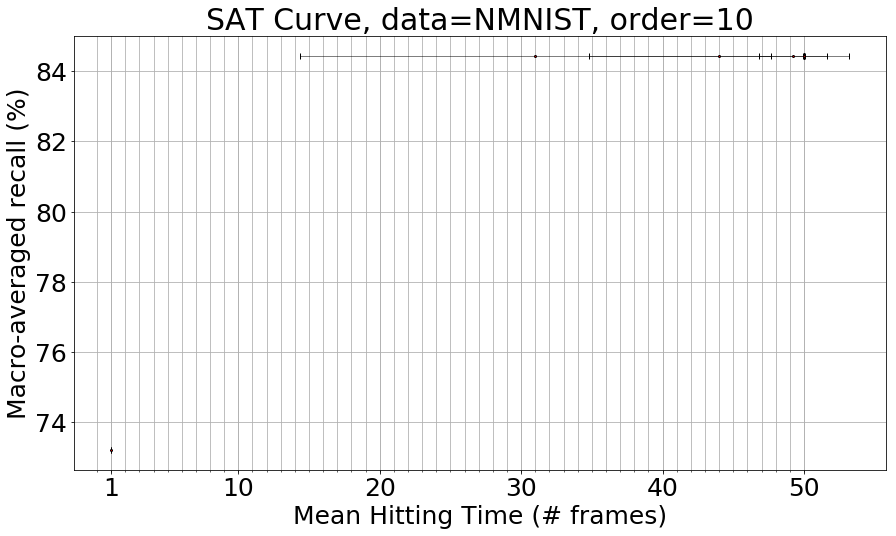

In [14]:
# Start plotting SP curve with variance
######################################
# Parameters
x = ls_mht
y = 100. * ls_sns[:, -2] # macro-averaged recall
xerr =  np.sqrt(ls_vht)
title = "SAT Curve, data=NMNIST, order={}".format(order_sprt)
xlabel = "Mean Hitting Time (# frames)"
ylabel = "Macro-averaged recall (%)"

# Size
plt.rcParams["font.size"] = 25
fig, ax = plt.subplots(figsize=(13,8))
fig.patch.set_facecolor('white')
# Scale
#ax.set_xscale('log')
# Grid
major_ticks = np.arange(0, duration + 1, 10)
major_ticks[0] += 1
minor_ticks = np.arange(0, duration + 1, 1)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_xticklabels(['0, 10, 20, 30, 40, 50'])
for axis in [ax.xaxis, ax.yaxis]: # ?
    axis.set_major_formatter(ScalarFormatter())
    axis.set_minor_formatter(NullFormatter())
    
# Plot
plt.errorbar(
    x, y, 
    xerr = xerr, 
    capsize=3, 
    fmt='o', 
    markersize=2, 
    ecolor='black', 
    markeredgecolor = "black", 
    color='red',
    elinewidth=0.5)

plt.ylabel(ylabel)        
plt.xlabel(xlabel)
plt.grid(which='both')
#plt.legend(loc=4, fontsize='15')
plt.title(title)
#plt.xlim(0.95, duration+0.3)
#plt.ylim(88., 99.7) # v1
#plt.ylim(95, 99.7) # v2
plt.tight_layout()

# Save figure
# plt.savefig(***)

# 3. Plot Trajectories of LLRs

- min LLR.
    - $\mathrm{max}_k \mathrm{min}_{l \neq k} \mathrm{LLR}_{kl} (t)$ on a single plane
- min LLR for each class ($K$ plots).
    - $\mathrm{min}_{l \neq k} \mathrm{LLR}_{kl} (t)$. One $k$, one plane
- all LLRs for each class ($K$ plots in each of which there are $K$ - 1 types of trajectories).
    - $\mathrm{LLR}_{kl} (t)$, where $k \neq l$. One $k$, one plane.
- all LLRs, positive class mins (red) and negative class mins (blue).
    - $\mathrm{min}_{l \neq k} \mathrm{LLR}_{kl} (t)$, where `color = red` if $k = y_i$ else `color = blue`. 
- positive LLR row. All and each k.
    - $\mathrm{LLR}_{y_{i}\, l}$, where $l \neq y_i$

\begin{equation}
    \lambda(t) := 
    \begin{pmatrix}
    0                & \cdots &  \lambda_{1l}(t) & \cdots & \lambda_{1K}(t)\\
    \vdots           & \ddots &                  &        & \vdots \\
    -\lambda_{1l}(t) &        &                0 &        & \lambda_{kK}(t) \\
    \vdots           &        &                  & \ddots & \vdots \\
    -\lambda_{1K}(t) & \cdots & -\lambda_{kK}(t) & \cdots & 0
    \end{pmatrix}
\end{equation}

\begin{equation}
    \lambda_{kl}(t) := \log(\frac{p(X^{(1,t)}\,\,\,|y=k)}{p(X^{(1,t)}\,\,\,|y=l)})\,\,\, (k, l \in [K], K\in\mathbb{N})
\end{equation}


## 3-4-1. All LLR rows with minimum $l  

- $\mathrm{min}_{l\neq k} \mathrm{LLR}_{k\, l}$

In [16]:
num_trj = 1
plot_classes = [] # optional: default=[]
shuffle = True # currently not supported

In [17]:
# Initialization
llrs_trj = llrs_all[:num_trj]
labels_trj = labels_all[:num_trj]

# Restrict classes (optional)
llrs_trj, labels_trj = restrict_classes(llrs_trj, labels_trj, plot_classes)
labels_trj = labels_trj.numpy() if len(plot_classes) != 0 else labels_trj 

### Add max LLR to diag
llrs_trj = add_max_to_diag(llrs_trj)

### Extract min column: shape change (batch, duration, num classes num classes) -> (batch, duration, num classes)
llrs_trj = tf.reduce_min(llrs_trj, axis=3)

# Shuffle (optional)
if shuffle:
    idx_perm = np.random.permutation(labels_trj.shape[0]) # randomly take some LLRs
    llrs_trj = tf.constant(llrs_trj.numpy()[idx_perm], dtype=tf.float32)
    labels_trj = tf.constant(labels_trj[idx_perm], dtype=tf.int32)
    
# Pick some out
llrs_trj = llrs_trj[:num_trj].numpy()
labels_trj = labels_trj[:num_trj].numpy()

In [18]:
# Color definitions
ls_color = [
    "red",
    "blue",
]
ls_plotLabel =[
    "min_l {LLR_k =yi l}",
    "min_l {LLR_k!=yi l}",
] 

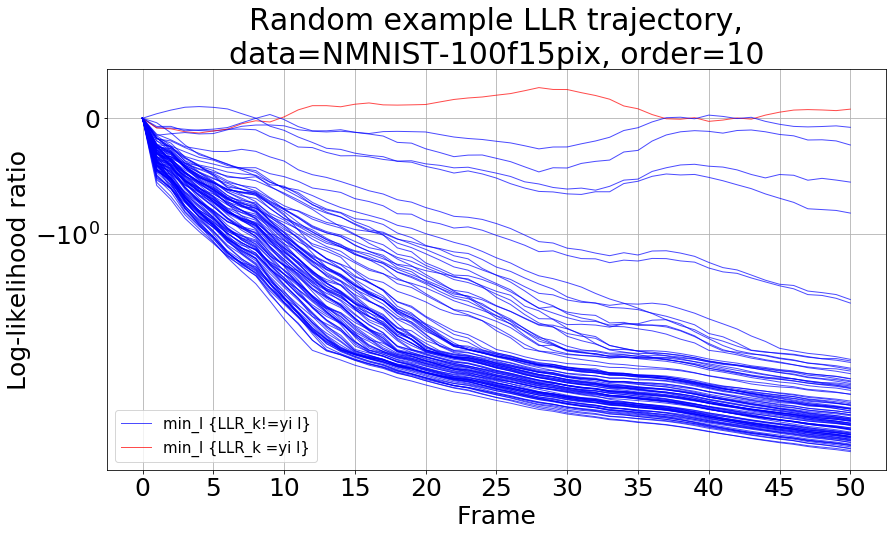

In [19]:
# Start plotting trajectory
######################################
# Parameters
x = [i for i in range(0, duration+1)]
title = "Random example LLR trajectory,\ndata=NMNIST-100f15pix, order={}".format(order_sprt)
xlabel = "Frame"
ylabel = "Log-likelihood ratio"

# Size
plt.rcParams["font.size"] = 25
plt.figure(figsize=(13,8)) 

# plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
#     [])

_tmp = set()
for itr_llrs, itr_label in zip(llrs_trj, labels_trj):
    itr_llrs = np.transpose(itr_llrs, [1, 0])
        # (num classes, duration)
    for itr_i, itr_trj in enumerate(itr_llrs):
        y = np.append(0, itr_trj)
        
        # Color and plot label
        if itr_i == itr_label:
            color = ls_color[0]
            if not (_tmp >= {ls_plotLabel[0]}):
                plot_label = ls_plotLabel[0]
                _tmp.add(plot_label)
            else:
                plot_label = None
        else:
            color = ls_color[1]
            if not (_tmp >= {ls_plotLabel[1]}):
                plot_label = ls_plotLabel[1]
                _tmp.add(plot_label)    
            else:
                plot_label = None
        
        # Plot
        plt.plot(
            x, y, 
            color=color, 
            marker='o', 
            linewidth=1, 
            markersize=0,
            label=plot_label,
            alpha=0.7
            )
        cnt += 1

plt.xlabel(xlabel)
plt.ylabel(ylabel)        
plt.yscale("symlog")
plt.grid(True)
plt.legend(fontsize='15')
plt.title(title)
plt.xticks([i for i in range(0, duration + 1)])
#plt.xlim(-0.1, 20.1)
plt.locator_params(axis='x', nbins=11)
plt.tight_layout()

# Save figure 
# plt.savefig(
#     "./traj_order{}.svg".format(order_sprt), 
#     format="svg", 
#     dpi=1200)

## 3-1. Positive LLR row

- $\mathrm{LLR}_{y_{i}\, l}$, where $l \neq y_i$

In [20]:
num_trj = 10
plot_classes = [] # optional: default=[]
shuffle = True # currently not supported

In [22]:
# Initialization
llrs_trj = llrs_all[:50]
labels_trj = labels_all[:50]

# Restrict classes (optional)
llrs_trj, labels_trj = restrict_classes(llrs_trj, labels_trj, plot_classes)
labels_trj = labels_trj.numpy() if len(plot_classes) != 0 else labels_trj ################### TMmod 20210106 ###############

### Extract positive rows: shape change -> (batch, duration, num classes)
llrs_trj = extract_positive_row(llrs_trj, labels_trj)

# Shuffle (optional)
if shuffle:
    idx_perm = np.random.permutation(labels_trj.shape[0]) # randomly take some LLRs
    llrs_trj = tf.constant(llrs_trj.numpy()[idx_perm], dtype=tf.float32)
    labels_trj = tf.constant(labels_trj[idx_perm], dtype=tf.int32)

# Pick some up
llrs_trj = llrs_trj[:num_trj].numpy()
labels_trj = labels_trj[:num_trj].numpy()

In [26]:
# Color definitions
ls_color = [
    None
] * num_classes
ls_plotLabel =[
    "_"] * num_classes

In [1]:
# Start plotting trajectory
######################################
# Parameters
x = [i for i in range(0, duration+1)]
title = "Random example LLR trajectory, data=NMNIST, order={}".format(order_sprt)
xlabel = "Frame"
ylabel = "Log-likelihood ratio"

# Size
plt.rcParams["font.size"] = 25
plt.figure(figsize=(13,8)) 

_tmp = set()
for itr_llrs, itr_label in zip(llrs_trj, labels_trj):
    itr_llrs = np.transpose(itr_llrs, [1, 0])
    itr_llrs = np.delete(itr_llrs, obj=itr_label, axis=0)
        # (num classes - 1, duration)
    for itr_trj in itr_llrs:
        y = np.append(0, itr_trj)
        
        # Color
        color = ls_color[itr_label]
        
        # Label
        if _tmp >= {itr_label}:
            plot_label = None
        else:
            _tmp.add(itr_label)
            plot_label = ls_plotLabel[itr_label]
        
        # Plot
        plt.plot(
            x, y, 
            color=color, 
            marker='o', 
            linewidth=1, 
            markersize=0,
            label=plot_label
            )
        cnt += 1

plt.xlabel(xlabel)
plt.ylabel(ylabel)        
plt.yscale("symlog")
plt.grid(True)
#plt.legend(fontsize='15')
plt.title(title)
plt.xticks([i for i in range(0, duration + 1)])
#plt.xlim(-0.1, 20.1)

plt.tight_layout()

# Save figure 
# plt.savefig(
#     "./traj_order{}.svg".format(order_sprt), 
#     format="svg", 
#     dpi=1200)

NameError: name 'duration' is not defined

## 3-3. Positive LLR row with minimum $l$
- $\mathrm{min}_{l (\neq y_i)} \mathrm{LLR}_{y_{i}\, l}$

In [53]:
num_trj = 20
plot_classes = [] # optional: default=[]
shuffle = True # currently not supported

In [60]:
# Initialization
llrs_trj = llrs_all[:100]
labels_trj = labels_all[:100]

# Restrict classes (optional)
llrs_trj, labels_trj = restrict_classes(llrs_trj, labels_trj, plot_classes)
labels_trj = labels_trj.numpy() if len(plot_classes) != 0 else labels_trj ################### TMmod 20210106 ###############
### Add max LLR to diag
llrs_trj = add_max_to_diag(llrs_trj)

### Extract positive rows: shape change -> (batch, duration, num classes)
llrs_trj = extract_positive_row(llrs_trj, labels_trj)

### Extract min column: shape change (batch, duration, num classes) -> (batch, duration)
llrs_trj = tf.reduce_min(llrs_trj, axis=2)

# Shuffle (optional)
if shuffle:
    idx_perm = np.random.permutation(labels_trj.shape[0]) # randomly take some LLRs
    llrs_trj = tf.constant(llrs_trj.numpy()[idx_perm], dtype=tf.float32)
    labels_trj = tf.constant(labels_trj[idx_perm], dtype=tf.int32)
    
# Pick some up
llrs_trj = llrs_trj[:num_trj].numpy()
labels_trj = labels_trj[:num_trj].numpy()

In [37]:
# Color definitions
ls_color = [
    None
] * num_classes
ls_plotLabel =[
    "_"] * num_classes

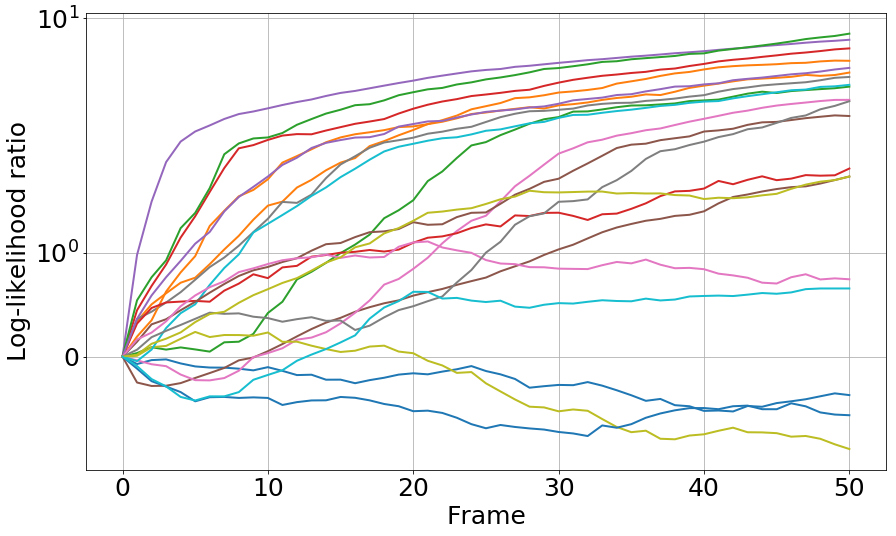

In [61]:
# Start plotting trajectory
######################################
# Parameters
x = [i for i in range(0, duration+1)]
title = "Random example LLR trajectory, data=NMNIST, order={}".format(order_sprt)
xlabel = "Frame"
ylabel = "Log-likelihood ratio"

# Size
plt.rcParams["font.size"] = 25
plt.figure(figsize=(13,8)) 

_tmp = set()
for itr_trj, itr_label in zip(llrs_trj, labels_trj):
    y = np.append(0, itr_trj)

    # Color
    color = ls_color[itr_label]

    # Label
    if _tmp >= {itr_label}:
        plot_label = None
    else:
        _tmp.add(itr_label)
        plot_label = ls_plotLabel[itr_label]

    # Plot
    plt.plot(
        x, y, 
        color=color, 
        marker='o', 
        linewidth=2, 
        markersize=0,
        label=plot_label
        )

plt.xlabel(xlabel)
plt.ylabel(ylabel)        
plt.yscale("symlog")
plt.grid(True)
#plt.legend(fontsize='15')
#plt.title(title)
plt.xticks([10 * i for i in range(0, 6)])
#plt.xlim(-0.1, 20.1)

plt.tight_layout()

# Save figure 
# filename = "/data/t-miyagawa/sprt_multiclass/nosaic_mnist-1000f/graphs/LLRtrajectory_UCF101v4"
# plt.savefig(
#     "{}.svg".format(filename), 
#     format="svg", 
#     dpi=1200)